# CIS 545 Homework 4: Machine Learning

*Due Date: **4th April 2022 at 10:00PM EST**, 100 points total (= 87 autograded + 13 manually graded).*

**PLEASE READ THE FAQ as you do this assignment!** It's pinned on Piazza and we TAs work really hard to keep it updated with everything you might need to know or anything we might have failed to specify. Writing these HWs and test cases gets tricky since students always end up implementing solutions that we did not anticipate and thus could not have prepared the grader correctly for.

# Libraries and Setup Jargon
Run the following cells to set up the notebook.

When prompted for a selection, select the number that is associated with java 8 (this should be option 2)

In [92]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
* 2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2


Please make sure you enter your **8 digit Penn ID** in the student ID field below.

In [93]:
%%capture
!pip install penngrader
from penngrader.grader import *

#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 999999999999 # YOUR PENN-ID GOES HERE AS AN INTEGER

grader = PennGrader(homework_id = 'CIS545_Spring_2022_HW4', student_id = STUDENT_ID)

In [94]:
# Versioning again
!pip install pandas==1.1.5

In [95]:
# Sklearn and Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive

In [96]:
!apt update
!apt install gcc python-dev libkrb5-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graph

# **Part I:** Preprocessing and Modeling in `scikit-learn` (65 points)

## **1.1** Data Loading and Preprocessing


### **1.1.1** Read

We are using one CSV for this homework, `rideshare_kaggle.csv` from [this Kaggle](https://www.kaggle.com/brllrb/uber-and-lyft-dataset-boston-ma) dataset. The price corresponds to the prices of each ride. Go to the Kaggle link and create an account, go to Account, click on Create New API Token to get the API key in the form of a json file ```kaggle.json```! This can be helpful for your project if you decide to use Kaggle. 

Load `rideshare_kaggle.csv` as `rides_df`.

In [ ]:
!pip install kaggle

Click on the folder button on the left panel, then upload the ```kaggle.json``` file to content! Use the image.png button on the left panel.

Once done, simply run the following commands!

In [ ]:
# Create the kaggle directory and read the uploaded kaggle.json file
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!kaggle datasets download -d brllrb/uber-and-lyft-dataset-boston-ma

 85% 38.0M/44.5M [00:00<00:00, 87.0MB/s]
100% 44.5M/44.5M [00:00<00:00, 85.0MB/s]


In [ ]:
# Unzip folder in Colab content folder
!unzip /content/uber-and-lyft-dataset-boston-ma.zip

Archive:  /content/uber-and-lyft-dataset-boston-ma.zip
  inflating: rideshare_kaggle.csv    


In [ ]:
# TO-DO: Read the csv file and save it to a dataframe called "rides_df"
rides_df = pd.read_csv('rideshare_kaggle.csv')

### **1.1.2** Check Nulls

Remove all the rows that have NaN in price. Store this into `rides_df`.

In [ ]:
# TO-DO: Remove NaN in the price column
rides_df = rides_df.dropna()

In [ ]:
# 2 points
grader.grade(test_case_id = 'check_remove_nans', answer = rides_df.shape)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.2** EDA

Exploratory Data Analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.


### 1.2.0 Tidying Up

Upon inspection, we can see that the `product_id` column isn't going to be useful since `name` already contains the information that we need. Likewise, we won't need to use `timestamp` since `datetime` gives us more interpretable information.

In [ ]:
# TO-DO: Drop the "product_id" and "timestamp" columns, but keep everything else for now
rides_df = rides_df.drop(columns=['product_id','timestamp'])

The `name` column isn't a very self-explanatory column title though, so let's rename it `fare_type`.

In [ ]:
# TO-DO: Rename the "name" column so that the new name is "fare_type"
rides_df = rides_df.rename(columns={'name':'fare_type'})

As you might suspect, there is not necessarily a single recipe for conducting EDA that works for all datasets. We are guiding you through a few standard EDA tasks, but in order to build a good model, you will need to do some more EDA on your own.


### 1.2.1 Distribution of Fare Types by Carrier

Create a Pandas series that shows the number of rides (i.e. number of rows) for each fare type for Uber rides. Call this series `uber_type_counts`, which has been sorted in **descending order** (highest to lowest counts)

Repeat this exercise to get the number of rides for each fare_type for Lyft rides and call it `lyft_type_counts`.

_(Note: There should be a column that tells you whether a ride was facilitated by Uber or Lyft. You should not need to do any string manipulation on the `fare_type` column)_

In [ ]:
# TO-DO: Create uber_type_counts
uber_type_counts = rides_df[rides_df['cab_type']=='Uber']['fare_type'].value_counts(ascending=False)

In [ ]:
# TO-DO: Create lyft_type_counts
lyft_type_counts = rides_df[rides_df['cab_type']=='Lyft']['fare_type'].value_counts(ascending=False)

In [ ]:
# 5 points
grader.grade(test_case_id = 'carrier_type_counts', answer = (uber_type_counts, lyft_type_counts))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now let's visualize this! This is going to be a bit more involved than the plots you've made in HW #1 since we want to help you develop your attention to detail. Most importantly, you always want your plots to be clear and interpretable to your reader.

**TO-DO:** Plot a bar chart showing the frequency distribution of all fare types for both Uber and Lyft rides on a _single_ set of axes. Make sure that:
- The graph has an appropriate title and axes labels
- The $y$-axis has been truncated to show a range between 50,000 to 56,000
- Bars are color coded by `cab_type` (carrier):
  - All Uber fare type bars are colored _**black**_
  - All Lyft fare type bars are colored _**magenta**_.
  - You must include the corresponding legend/color key for each platform/carrier (`cab_type`)
- Your graph is clearly legible _(e.g. there should not be overlapping text)_

**REMINDER:** Do NOT save the plot as a separate image file! You must ensure that the plot is displayed in your Colab notebook before submission. If you do not hit "Restart and Run All" to ensure this before your final submission, we _**will deduct -3 points from your final score.**_

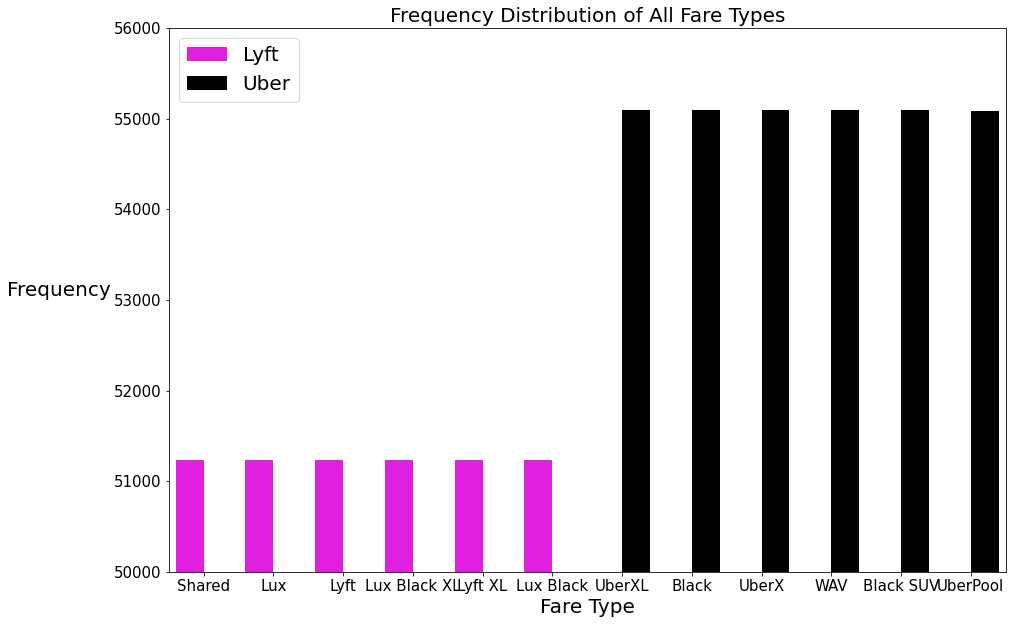

In [ ]:
# TO-DO: Plot the chart using seaborn's countplot function. 
#        Please make sure to address all bullet points noted above!
#        This will be manually graded and worth 5 points.
plt.figure(num = 1, figsize = (15,10))
bar = sns.countplot(x = 'fare_type',data = rides_df, hue = 'cab_type',palette=('magenta','black'))
bar.set_xlabel(xlabel = 'Fare Type',fontsize = 20)
bar.set_ylabel(ylabel = 'Frequency                ',fontsize = 20, rotation=0)
bar.set_title(label = 'Frequency Distribution of All Fare Types', fontsize = 20)
plt.ylim(50000,56000)
plt.legend(loc = 'upper left',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### **1.2.2** Use the `datetime` column to extract the calendar date, minutes, and seconds

Notice that while this dataset has already extracted the day of the month, the month, and hour of the day from the `'datetime'` column as separate features already, this may not be entirely useful to us. We may prefer to keep this as an actual date, but more importantly, the time components are of interest to us since we don't actually have the minutes and seconds from the timestamp yet.

_**Converting to `datetime` Object**_

First, use the `striptime` function from the `datetime` package to convert the "datetime" string into a datettime object.

In [ ]:
# TO-DO: Convert this into a datetime object 
rides_df['datetime'] = rides_df['datetime'].apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

_**Extracting Time Components**_

Now extract the date (`YYYY-mm-dd` format), minutes, and seconds from it to be stored in columns called "date", "min" and "sec" respectively in the `rides_df` dataframe. Make sure to double-check that the dtypes of these columns are what you would expect!

_(Note: the `hour` column already exists in the original dataframe so we don't need to extract it)_

In [ ]:
# TO-DO: Extract the calendar date (YYYY-mm-dd format), the minutes, and seconds to separate columns
rides_df['date'] = rides_df['datetime'].dt.date
rides_df['min'] = rides_df['datetime'].apply(lambda x: x.minute)
rides_df['sec'] = rides_df['datetime'].apply(lambda x: x.second)

In [ ]:
# 4 points
grader.grade(test_case_id = 'check_date_minute_second', answer = [rides_df['date'].unique(),
                                                                  rides_df[['date', 'min', 'sec']].head()])

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


With that, we have no more use for the original `datetime` column so we can drop it. There are also some other columns that are useless to use so we'll drop them all at once:

In [ ]:
# TO-DO: Drop the 'id', 'datetime' 'timezone', 'long_summary', and 'icon' columns from rides_df
rides_df = rides_df.drop(columns=['id', 'datetime','timezone', 'long_summary', 'icon'])

### **1.2.3** Mean, Standard Deviation, Min, and Max

There are certain numeric features of interest to us that we want to examine sample statistics for.

Compute simple statistics - specifically the mean, standard deviation, min, and max - for each of the following numerical features and store them into lists in this order: `[distance, price, longitude, latitude]`

In other words, create 4 lists:
- **means** = `[distance_mean, price_mean, longitude_mean, latitude_mean]`
- **stdevs** = `[distance_sd, price_sd, longitude_sd, latitude_sd]`
- **mins** = `[distance_min, price_min, longitude_min, latitude_min]`
- **maxes** = `[distance_max, price_max, longitude_max, latitude_max]`

In [ ]:
# TO-DO: Create "means" list for distance, price, longitude, and latitude
means = [rides_df['distance'].mean(),rides_df['price'].mean(),rides_df['longitude'].mean(),rides_df['latitude'].mean()]

# TO-DO: Create "stdevs" list for distance, price, longitude, and latitude
stdevs = [rides_df['distance'].std(),rides_df['price'].std(),rides_df['longitude'].std(),rides_df['latitude'].std()]

# TO-DO: Create "mins" list for distance, price, longitude, and latitude
mins = [rides_df['distance'].min(),rides_df['price'].min(),rides_df['longitude'].min(),rides_df['latitude'].min()]

# TO-DO: Create "max" list for distance, price, longitude, and latitude
maxes = [rides_df['distance'].max(),rides_df['price'].max(),rides_df['longitude'].max(),rides_df['latitude'].max()]


In [ ]:
# 4 points
grader.grade(test_case_id = 'check_min_max_means_std', answer = (maxes, mins, stdevs, means))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.2.4** Correlation of Feature Variables

With such an overwhelming number of features, it can be somewhat exhausting to do bivariate analysis on every possible pair of features. While you certainly should, your first instinct should be to check for the correlation between features since certain models (e.g. Linear Regression) won't work well if we have strong multicollinearity.

_**Isolating Numerics from Categorical Features**_

Before anything else, it may help to create groups of the numeric vs. categorical variables

In [ ]:
# TO-DO: create a dataframe called numerics_df to keep the subset of numeric variables columns
numerics_df = rides_df.select_dtypes(include=['float64','int64'])

In [ ]:
# TO-DO: create a dataframe called categorical_df to keep the subset of non-numeric columns
categorical_df = rides_df.select_dtypes(exclude=['float64','int64'])

In [ ]:
# 2 points
grader.grade(test_case_id = 'check_typed_subsets', answer = [numerics_df.columns, categorical_df.columns])

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


_**Correlation Heatmap**_

Next, create a correlation matrix using `numerics_df` and call it `corr_matrix`. Using that, generate a correlation heatmap for these numeric features. Look into how to use the `seaborn` library to do this _(imported as `sns` above)_.

Like the plot in 1.2.1, we are going to be rather strict about the details and presentability when we manually grade this (out of **4 points**). Make sure your correlation heatmap meets the following criteria:
- Ensure that your heatmap is appropriately sized: all feature labels should be visible on both the $x$-axis and $y$-axis
- Use the `RdBu` color map to ensure that negative correlations are red and positive correlations are blue
- Standardize the color scale so that -1 takes the darkest red color, 0 is totally white, and +1 takes the darkest blue color 

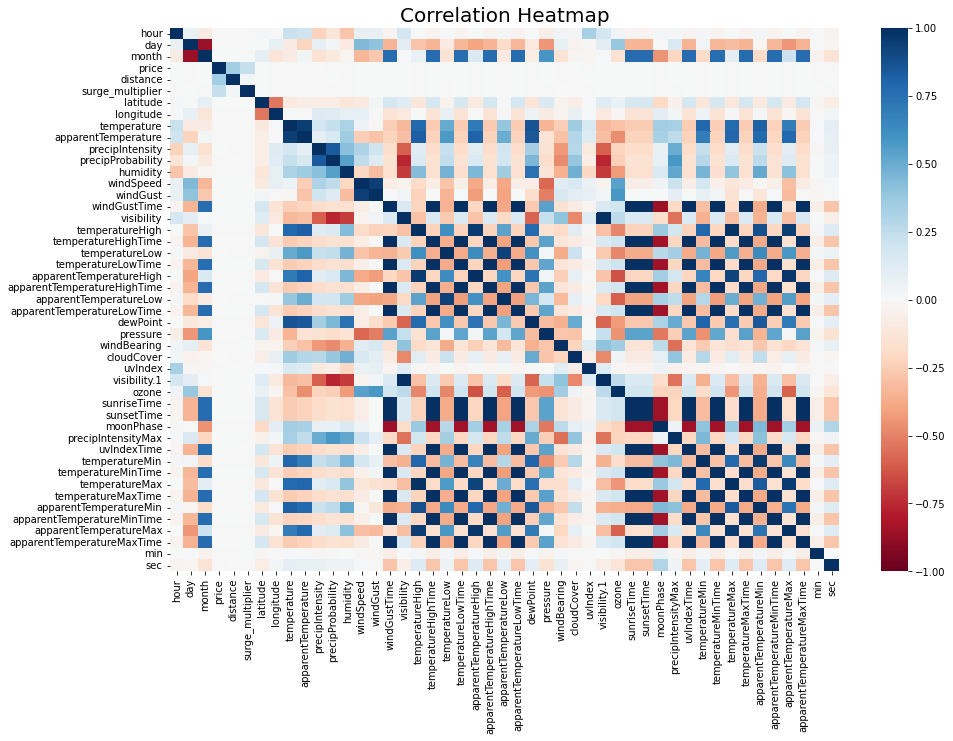

In [ ]:
# TO-DO: Get the correlation matrix
corr_matrix = numerics_df.corr()

# TO-DO: Plot correlation heatmap (4 points)
plt.figure(num=2,figsize = (15,10))
hm = sns.heatmap(corr_matrix,cmap='RdBu',vmin = -1, vmax = 1)
hm.set_title(label = 'Correlation Heatmap', fontsize = 20)
plt.show()

## **1.3** Feature Engineering

Feature engineering is the process of applying domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.

### **1.3.1** Proposed Ranking System for Ordinal Encoding

The `short_summary` column contains information on the weather at the timestamp for a particular ride. As such, in order to make the data useful as feature variables, we encode these weathers using _Ordinal Encoding_. If a certain type of weather makes it more difficult for drivers to drive, we want it to have a higher ranked value. Create a new column called `"weather_factor"` that contains these ordinal encodings (ranks).

**Clarifications**:
- To eliminate ambiguity, please rank the weather according to: `Clear < Partly Cloudy < Mostly Cloudy < Overcast < Possible Drizzle < Drizzle < Light Rain < Rain < Foggy`
- If the weather is Clear, assign the lowest rank of 0 to it.

In [ ]:
# TO-DO: Create a new column called "weather_factor" that takes a ranked integer value between 0 and 8.
dic = {'Clear':0,'Partly Cloudy':1, 'Mostly Cloudy':2, 'Overcast':3, 'Possible Drizzle':4, 'Drizzle':5,
       'Light Rain':6, 'Rain':7, 'Foggy':8}

def convertcol(x):
  return dic[x]

rides_df['weather_factor'] = rides_df['short_summary'].apply(lambda x: convertcol(x.strip()))  

In [ ]:
# 2 points
grader.grade(test_case_id = 'check_short_summary', answer = rides_df['weather_factor'][:10000])

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.3.2** Creating Target Variable - whether price exceeds mean threshold for the carrier

While this is an ideal dataset for regression modeling, there aren't any obvious choices for meaningful binary target variables for the purpose of classification modeling, which we will get to in Section 1.4. Thus, for the purpose of the exercise, we will need to design a binary target variable to work with: whether the price for a given ride is above the average price.

However, recall that this dataset combines data from both Lyft and Uber. While both carriers are competitors in the ridesharing industry, they are each different in their own way. As a result, it won't be meaningful to use a single mean price as a benchmark for our target variable; we will need to consider **each carrier's respective mean** price when comparing rides to that mean.

In [ ]:
# Consider the following features from the original rides_df dataframe.
new_df = rides_df[['date', 'hour', 'min', 'sec', 'price', 'weather_factor', 
                   'source', 'destination', 'cab_type', 'fare_type',
                   'distance', 'surge_multiplier', 'latitude', 'longitude',
                   'temperature', 'humidity', 'windGust', 'visibility',
                   'uvIndex', 'precipIntensity', 'precipProbability']]

In [ ]:
# TO-DO: Get mean price for Uber and Lyft
mean_uber = new_df[new_df['cab_type']=='Uber']['price'].mean()
mean_lyft = new_df[new_df['cab_type']=='Lyft']['price'].mean()

In [ ]:
# TO-DO: Create the "above_average" target variable as a new column in rides_df
#        where 1: above average score, 0: equal to or below average score for that carrier
def assign(x):
  if x['cab_type'] == 'Uber':
    if x['price'] > mean_uber:
      res = 1
    else:
      res = 0
  else:
    if x['price'] > mean_lyft:
      res = 1
    else:
      res = 0
  return res
new_df['above_average'] = new_df.apply(lambda x: assign(x), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
# 3 points
grader.grade(test_case_id = 'check_average_threshold', answer = (new_df[:1000]['above_average'].sum(),
                                                                 mean_uber,
                                                                 mean_lyft))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.3.3** Label-Encode the Product Types

Identify the remaining categorical features and convert them into label-encoded vectors. There are **2 categorical variables that need to be encoded**, `cab_type`, `fare_type`.

To do this, we use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) in the sklearn package. Make sure you keep track of the mappings for reference.

Assign all labels to `new_df` as `cab_type_label` and `fare_type_label`.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# TO-DO: Create label encoders for cab_type and fare_type
le = LabelEncoder()
le.fit(new_df['cab_type'].tolist())
new_df['cab_type_label'] = le.transform(new_df['cab_type'].tolist())
le = LabelEncoder()
le.fit(new_df['fare_type'].tolist())
new_df['fare_type_label'] = le.transform(new_df['fare_type'].tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# TO-DO: add as new columns to new_df (do not drop any columns yet)


In [ ]:
# 3 points
grader.grade(test_case_id = 'check_encoding_var', answer = [new_df['cab_type_label'][0],
                                                            new_df.shape,
                                                            new_df['fare_type_label'][0]])

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Let's write out the modified data we created to a file so that we can reuse it in Part II when we deal with Spark.

In [ ]:
combined_data_sec_2 = new_df.copy()
combined_data_sec_2.to_csv('/content/combined.csv')

### **1.3.4** Preprocessing: Split into Features and Label

Now that we have explored and cleaned our dataset, let's prepare it for a machine learning task. In this homework, you will work with various models and attempt to predict the price of ride. Since we converted the prices to binary labels above, you will actually predict whether the ride has high price (`above_average = 1`) or low price (`above_average = 0`) for classification and actual price for regression.

The features will be the encoded variables together with some other attributes: `weather_factor`, `fare_type_label`, `cab_type_label`, `distance`, `surge_multiplier`, `hour`, `temperature`, `precipIntensity` and `precipProbability`. The label will be the binary indicator created in 1.3.2, indicating if the price is above average. Store these two as `features` and `labels`, respectively.

In [ ]:
# TO-DO: stores features dataframe into variable called "features"
features = new_df[['weather_factor','fare_type_label','cab_type_label','distance','surge_multiplier','hour','temperature','precipIntensity','precipProbability']]

# TO-DO: store the binary classification target variable into "labels"
labels = new_df['above_average']

# TO-DO: store the regression target variable into "prices"
prices = new_df['price']

In [ ]:
# 3 points
grader.grade(test_case_id = 'check_features_labels', answer = (features.columns, labels.name, prices.name))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.4** Modeling (sklearn)

### **1.4.1** Split Data into Train and Test

Use scikit-learn's `train_test_split` function to split data for regression into train and test sets. The split should be 80-20 meaning 80% for training and rest for testing.

Since this part concerns regression, you should carefully think about what should be our target variable: should it be `labels` or `prices`?

**_IMPORTANT_: Please set the `random_state` parameter to `random_state = 42`** and store the resulting splits as `x_train, x_test, y_train,` and `y_test`.

In [ ]:
from sklearn.model_selection import train_test_split

# TO-DO: Conduct 80/20 train-test split with random_state = 42
x_train, x_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=42)

In [ ]:
# 4 points
grader.grade(test_case_id = 'check_train_test_split', answer = (x_train.shape, x_test.shape, y_train.shape, y_test.shape, y_test[:100]))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.4.2** Regression Models

#### (a) Linear Regression (Unregularized)

Use the `LinearRegression` class in scikit-learn to perform Linear Regression. Initialize the model with default parameters, fit the model to the training set, and then make predictions on the testing set.

Save your predictions in an array named `y_pred`, and report your R-squared score (saved it as a variable called `score`).

In [ ]:
from sklearn.linear_model import LinearRegression

# Your code here
li = LinearRegression()
li.fit(x_train,y_train)
y_pred = li.predict(x_test)
score = li.score(x_test,y_test)

In [ ]:
# 3 points
grader.grade(test_case_id = 'check_linear_reg', answer = [y_pred, score])

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (b) Ridge Regression

Use the `Ridge` class in scikit-learn to perform $L_2$ Regularized Linear Regression. Initialize the model with regularization strength `alpha = 1.0`, fit the model to the training set, and then make predictions on the testing set.

Report your $R^2$ score and save it as a variable called `ridge_score`.

In [ ]:
from sklearn.linear_model import Ridge

# Your code here
li = Ridge(alpha=1.0)
li.fit(x_train,y_train)
ridge_pre = li.predict(x_test)
ridge_score = li.score(x_test,y_test)

In [ ]:
# 2 points
grader.grade(test_case_id = 'check_ridge_reg', answer = ridge_score)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


_**Exam-Style Practice Questions:**_

_(While we will NOT grade this for the purpose of the HW, it is in your best interest to take just 30-60 seconds to think about this as I may very well put something similar in the final exam!_ 😉_)_

- What do you notice about the $R^2$ scores of the Ridge and unregularized Linear Regression above?
- If Ridge is supposed to "improve" Linear Regression, we may find it unusual if that is not happening here. Under what circumstances would we consider using Ridge over unregularized Linear Regression?
- Would you expect different results if we made `alpha` bigger ($\alpha \rightarrow \infty$)? smaller ($\alpha \rightarrow 0$)? Why or why not?

### **1.4.3** Classification Models

#### (a) Split Data into Train and Test

Repeat 1.4.1 again but this time where our target variable is now `labels` (not "prices").

Again, we will use scikit-learn's `train_test_split` function to split the data for the classification problem into train and test sets. The split should be 80-20 meaning 80% for training and the rest for testing.

**_IMPORTANT_: Again, please set the `random_state` parameter to `random_state = 42`** and store the resulting splits as `x_train, x_test, y_train,` and `y_test`.

In [ ]:
# TO-DO: Do a 80/20 train-test split with random_state = 42 but for labels as our target this time 
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# 4 points
grader.grade(test_case_id = 'check_class_split', answer = (x_train.shape, x_test.shape, y_train.shape, y_test.shape, y_test[:100]))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (b) PCA to Reduce Dimensionality

The goal of Principal Component Analysis is to reduce number of dimensions of our features.

_**Initial PCA**_

As a first step instantiate and fit `PCA` from scikit-learn on your training set.

Please remember that PCA is **not** scale-invariant! What does this imply you need to do first?

In [ ]:
# TO-DO: Instantiate and Fit PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
standard_x_train = scaler.fit_transform(x_train)
pca = PCA()
pca.fit(standard_x_train)

PCA()

_**Cumulative Explained Variance Ratios**_

Create an array of explained variance ratios and store it into a variable called `explained_variance_ratios`. Also, calculate the _cumulative_ explained variance ratios and store that into another variable called `cum_evr`.

In [ ]:
# TO-DO: Save the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratios = pca.explained_variance_ratio_
# TO-DO: Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = pca.explained_variance_ratio_.cumsum()

In [ ]:
explained_variance_ratios

array([0.29682274, 0.15131573, 0.13746778, 0.11202323, 0.10370233,
       0.0774083 , 0.07257586, 0.03293822, 0.01574581])

Now plot the _cumulative_ `explained_variance_ratio` against the number of components to decide the number of components you should keep.

As before, you should ensure that the plot follows the best practices you've developed over the past 2 plotting exercises in this HW. **This will be manually graded for 2 points**


_**CAUTION:** Recall that Python starts counting from 0, but this would make it very intuitive when reading from your graph. We strongly recommend that you modify the x-axis of your graph so that the **number of components begins at 1**. Otherwise, you may risk making silly mistakes in the subsequent sections._

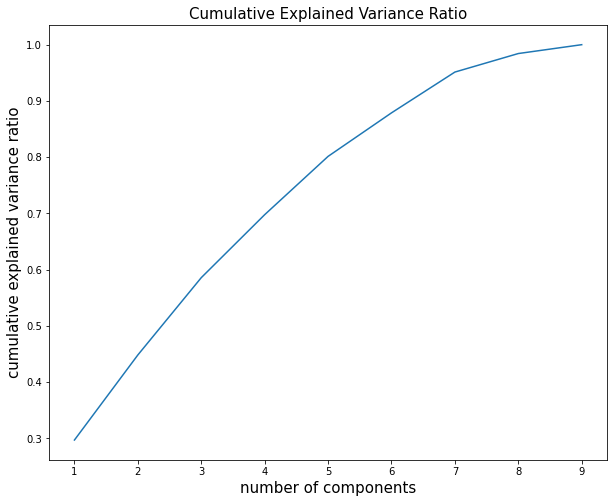

In [ ]:
# TO-DO: find optimal num components to use (n) by plotting explained variance ratio (2 points)
# Plot (1 point for correct shape)
# Aesthetics (1 point for title AND both axes labels)
plt.figure(num=3,figsize=(10,8))
plt.plot(range(1,len(cum_evr)+1),cum_evr)
plt.xlabel('number of components',fontsize=15)
plt.ylabel('cumulative explained variance ratio',fontsize=15)
plt.title('Cumulative Explained Variance Ratio',fontsize=15)
plt.show()

In [ ]:
# 2 points
grader.grade(test_case_id = 'check_pca_explained_variance', answer = explained_variance_ratios)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


_**Final PCA**_

Using your results above to help you decide the number of components to keep, choose a number (`n`) that explains **at least 80% of total variance** in the dataset. Then re-fit and transform your PCA on the training set using the number of components you decided.

Remember that your PCA should be trained on the training set (`x_train`) but only transformed on the test set (`x_test`).

Call your transformed set of principal components `x_test_pca` in order to submit it to the autograder.

In [ ]:
# TO-DO: Get transformed set of principal components on x_test
scaler = StandardScaler()
standard_x_train = scaler.fit_transform(x_train)
pca = PCA(n_components=5)
pca.fit(standard_x_train)
scaler = StandardScaler()
standard_x_test = scaler.fit_transform(x_test)
x_test_pca = pca.transform(standard_x_test)

In [ ]:
# 2 points
grader.grade(test_case_id = 'check_fitted_pca', answer = (x_test_pca[:10,:]))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


_**Visualizing Top 2 Principal Components**_

Just to visualize what's going on (separate from what you just did), use PCA once more but this time to reduce the number dimensions to 2 and plot the first 5000 rows for each component. PCA should be applied to the training data in this case after the required transformations.

**This will be manually graded** so as before, make sure you fully title and label your plot! We are specifically looking to see if you understand which component goes on the x-axis and which goes on the y-axis in this particular case.

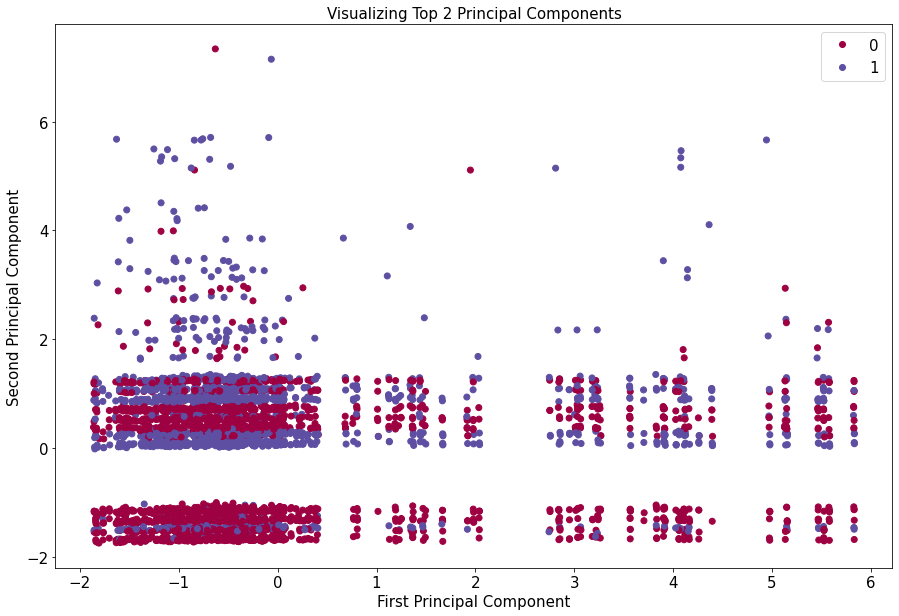

In [ ]:
# TO-DO: Visualize 2 components of PCA when applied to the training data (2 points)
pca1 = PCA(n_components=2)
pca_visualizing = pca1.fit_transform(standard_x_train)[0:5000,:]
plt.figure(num=4,figsize=(15,10))
scatter = plt.scatter(pca_visualizing[:,0],pca_visualizing[:,1],c=y_train[0:5000], cmap='Spectral')
plt.xlabel('First Principal Component', fontsize = 15)
plt.ylabel('Second Principal Component',fontsize = 15)
plt.title('Visualizing Top 2 Principal Components',fontsize = 15)
plt.legend(handles = scatter.legend_elements()[0],labels=list(y_train[0:5000]),fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### (c) Logistic Regression

1. Fit the logistic regression on your Final Principal Components data using your optimal `n`.
2. Make predictions on the test set.
3. Report accuracy for the test set and call it `test_accuracy`

In [ ]:
from sklearn.linear_model import LogisticRegression

# TO-DO: Instantiate, fit, predict, and score logistic regression
clf = LogisticRegression()
clf.fit(pca.transform(standard_x_train),y_train)
pre = clf.predict(x_test_pca)
test_accuracy = clf.score(x_test_pca,y_test)

In [ ]:
# 4 points
grader.grade(test_case_id = 'check_lr', answer = test_accuracy)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **Part II:** Distributed Machine Learning with Spark (35 points)

Apache Spark ML is a machine learning library that consists of common learning algorithms and utilities, including classification, regression, clustering, collaborative filtering, dimensionality reduction, and underlying optimization primitives.

**Why Spark ML?**

Moving to the Big Data Era requires heavy iterative computations on very large datasets. Standard implementations of machine learning algorithms require very powerful machines to be able to run. However, depending on high-end machines is not advantageous due to their high price and improper costs of scaling up. The idea of using distributed computing engines is to distribute the calculations to multiple low-end machines (commodity hardware) instead of a single high-end one. _This **definitely speeds up** the learning phase and allows us to create better models._

Read more about it with the python documentation **[here](https://spark.apache.org/docs/latest/ml-guide.html)**.

Run the code below to set up Spark.

In [ ]:
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
--2022-04-05 04:18:25--  https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228834641 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop3.2.tgz’

spark-3.1.2-bin-had 100%[===================>] 218.23M  20.1MB/s    in 12s     

2022-04-05 04:18:38 (18.6 MB/s) - ‘spark-3.1.2-bin-hadoop3.2.tgz’ saved [228834641/228834641]

     |████████████████████████████████| 43 kB 46 kB/s 
     |████████████████████████████████| 154 kB 6.0 MB/s 
     |████████████████████████████████| 3.6 MB 9

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
# Graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

#### **2.1** Initializing Spark Data

We have the spark setup ready. Now we need the data for our ML algorithms. We will use the data you processed in Section 1 but in Spark. 

Read in the .csv that you created into a Spark dataframe (`sdf`). Make sure to set the inferSchema flag to True when you do this so that the columns are the correct datatypes and not all strings.

In [ ]:
# TO-DO: Read in the csv
sdf = spark.read.csv('/content/combined.csv',header= True, inferSchema = True)

Print out the Dataframe Schema and verify the datatypes. 


In [ ]:
#TO-DO: Verify schema 
sdf.printSchema

<bound method DataFrame.printSchema of DataFrame[_c0: int, date: string, hour: int, min: int, sec: int, price: double, weather_factor: int, source: string, destination: string, cab_type: string, fare_type: string, distance: double, surge_multiplier: double, latitude: double, longitude: double, temperature: double, humidity: double, windGust: double, visibility: double, uvIndex: int, precipIntensity: double, precipProbability: double, above_average: int, cab_type_label: int, fare_type_label: int]>

Great job, we have the processed data now. For Spark ML, we need to create a feature column which has all features concatenated and a single column for labels, which we already have!
We will use `VectorAssembler()` to create a feature vector from all categorical and numerical features and we call the final vector as “features”.
First list all columns in the data and store it in a list named all_columns.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# TO-DO: store all columns in the data and store it in a list called "all_columns"
all_columns = sdf.columns

Create a list of columns which you don't want to include in your features (i.e. the original columns of labels and probably other columns which don't help the machine learning model). Name this list `drop_columns`.

In [ ]:
# TO-DO: Create drop_columns
drop_columns = ['_c0','date','price','source','destination','cab_type','fare_type','above_average']

Now using `drop_columns` or otherwise, create a list called `columns_to_use` that contains the names of all surviving columns.

In [ ]:
# TO-DO: Create columns_to_use
columns_to_use = [item for item in all_columns if item not in drop_columns]

In [ ]:
# 3 points
grader.grade(test_case_id = 'check_columns_to_use', answer = columns_to_use)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Create a VectorAssembler object with columns you want to use. Name your output column as `features` (i.e. they are the features you wanna use later).

In [ ]:
# TO-DO: Create VectorAssembler object (to be used later)
assembler = VectorAssembler(inputCols= columns_to_use,outputCol= "features")

## **2.2** Create Pipeline

Now we will create a pipeline with many stages. For this data, we just need a single stage with the assembler, but you could have other stages before that where you perform operations on the data like converting categorical strings in the features to numeric values, or do feature scaling operations.

In this step, we will create a pipeline with a single stage — the assembler. Fit the pipeline to your data and create the transformed dataframe and name it `modified_data_sdf`.

In [ ]:
from pyspark.ml import Pipeline

# Your code goes here
pipe = Pipeline(stages = [assembler])
modified_data_sdf = pipe.fit(sdf).transform(sdf)
modified_data_sdf.show()

+---+----------+----+---+---+-----+--------------+----------------+--------------------+--------+------------+--------+----------------+--------+---------+-----------+--------+--------+------------------+-------+---------------+-----------------+-------------+--------------+---------------+--------------------+
|_c0|      date|hour|min|sec|price|weather_factor|          source|         destination|cab_type|   fare_type|distance|surge_multiplier|latitude|longitude|temperature|humidity|windGust|        visibility|uvIndex|precipIntensity|precipProbability|above_average|cab_type_label|fare_type_label|            features|
+---+----------+----+---+---+-----+--------------+----------------+--------------------+--------+------------+--------+----------------+--------+---------+-----------+--------+--------+------------------+-------+---------------+-----------------+-------------+--------------+---------------+--------------------+
|  0|2018-12-16|   9| 30|  7|  5.0|             2|Haymarket S

Now that we have the data in the format we need, we will create our train and test sets.

Conduct a train-test split where 80% of the data is assigned to the training set while the remaining 20% is assigned to the testing set.

**Clarifications:**
- Name these `train_sdf` and `test_sdf` respectively.
- Add the argument `seed = 24` in the function to fix the random state in order to ensure consistency with our results.

In [ ]:
# TO-DO: Do 80/20 train-test split with seed = 24
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8,0.2],seed = 24)

In [ ]:
# 2 points
grader.grade(test_case_id = 'check_train_test_split_spark', answer = (train_sdf.count(), test_sdf.count()))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **2.3** LASSO Regularized Linear Regression

**Logistic Regression Using SparkML**

Time to do the cool stuff! Let's train a Logistic Regression model to our data and try to predict whether a ride will be above the average price for that carrier/platform/cab_type again.

This time, we will use "Big" data tools to help us build a Logistic Regression model for binary classification.

Look up the documentation online and try to understand how to implement this.

**Model 1: Train a Model without any Regularization.**

In [ ]:
from pyspark.ml.classification import LogisticRegression

# TO-DO: Instantiate and fit Logistic Regression model to training data
LR = LogisticRegression(featuresCol="features",labelCol="above_average").fit(train_sdf)

In [ ]:
# TO-DO: Get training accuracy
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='above_average')
predictions_train = LR.transform(train_sdf)
training_accuracy = evaluator.evaluate(predictions_train)

Now, find out how good the model actually is and see if it overfits to the training data.

Predict the label for `above_average` for your test data _(Hint: it is called 'transform' in Spark ML)_

In [ ]:
# TO-DO: Make predictions on testing set
predictions_test = LR.transform(test_sdf)

Evaluate the performance using the area under the ROC curve using 'BinaryClassificationEvaluator' object in the Spark ML Regression library.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# TO-DO: Get training accuracy and save to variable called "training_accuracy"


# TO-DO: Get AUC ROC score and save to variable called "test_predictions_log"
test_predictions_log = evaluator.evaluate(predictions_test,{evaluator.metricName:"areaUnderROC"})

In [ ]:
# 8 points
grader.grade(test_case_id = 'check_logistic_without_reg', answer = (training_accuracy, test_predictions_log))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Model 2: Train a Model with Regularization.**

Now, we will add regularization to avoid overfitting. 

Play around with different regularization parameters - try out LASSO (L1), Ridge (L2) and elastic net (combination of L1 and L2) and different regularization hyperparameters when initializing 3 different regularized logistic regression models. 

Compare these with each other and the non regularized regression done above.

Make sure to evaluate the performance on test data using the same metric as above(area under ROC curve)

In [ ]:
# TO-DO: LASSO/L1 regularized model's AUC ROC score and save to "test_area_l1" 
LRL1 = LogisticRegression(featuresCol="features",labelCol="above_average",regParam=0.1, elasticNetParam=1).fit(train_sdf)
predictions_test_L1 = LRL1.transform(test_sdf)
test_area_l1 = evaluator.evaluate(predictions_test_L1,{evaluator.metricName:"areaUnderROC"})

# TO-DO: Ridge/L2 regularized model's AUC ROC score and save to "test_area_l2"
LRL2 = LogisticRegression(featuresCol="features",labelCol="above_average",regParam=0.1, elasticNetParam=0.0).fit(train_sdf)
predictions_test_L2 = LRL2.transform(test_sdf)
test_area_l2 = evaluator.evaluate(predictions_test_L2,{evaluator.metricName:"areaUnderROC"})

# TO-DO: Your choice of Elastic Net model's AUC ROC score and save to "test_area_elastic"
LR_elastic = LogisticRegression(featuresCol="features",labelCol="above_average",regParam=0.1, elasticNetParam=0.5).fit(train_sdf)
predictions_test_elastic = LR_elastic.transform(test_sdf)
test_area_elastic = evaluator.evaluate(predictions_test_elastic,{evaluator.metricName:"areaUnderROC"})

In [ ]:
# 6 points
grader.grade(test_case_id = 'check_logistic_with_reg', answer = (test_area_l1, test_area_l2, test_area_elastic))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **2.4** Random Forest

If you are looking to win Kaggle competitions, you definitely must know about Random Forests, Boosted Trees, etc. These ensemble methods generalize and work surprisingly well for a lot of classification problems and sometimes for regression problems (though regression trees are not the focus of this course).

Let's give it a go. Similar to what you did for the Logistic Regression model, create a Random Forest classifier model and fit it to the training data.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer

# TO-DO: Instantiate and fit RF Model to training data
RF = RandomForestClassifier(featuresCol = "features", labelCol = "above_average", numTrees = 20, maxDepth = 10).fit(train_sdf)

This time, get predictions on both the training and testing sets.

In [ ]:
# TO-DO: Get predictions and save to "train_pred" and "test_pred" respectively
train_predictions_rf = RF.transform(train_sdf)
test_predictions_rf = RF.transform(test_sdf)


Evaluate only using the Area Under the ROC Curve (AUC ROC) metric this time.

In [ ]:
# TO-DO: Evaluate predictions using AUC ROC for both train and test
#        and call these "train_area" and "test_area" respectively
train_area = evaluator.evaluate(train_predictions_rf,
                                {evaluator.metricName: "areaUnderROC"})
test_area = evaluator.evaluate(test_predictions_rf,
                                {evaluator.metricName: "areaUnderROC"})

In [ ]:
# 8 points
grader.grade(test_case_id = 'check_random_forest', answer = (train_area, test_area))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


##**2.5** Dimensionality Reduction Using PCA

We will again use the powerful PCA to reduce the dimensions and project the data onto a lower dimensional space and fit a logistic regression on the new projected data.

You will need to choose a new appropriate value for the number of dimensions.

_Steps for this section:_
1.   Initialize a PCA model with the appropriate number of dimensions.
2.   Fit the model using the training data
3.   Get the PCA features from the trained model
4.   Train a Logistic Regression model using the PCA features
5.   Evaluate the performance on the test set using the Area Under the ROC Curve (AUC ROC) metric

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
# TO-DO:
standardScaler = StandardScaler(inputCol='features',outputCol='standard_features')
stand_model = standardScaler.fit(train_sdf)
stand_train = stand_model.transform(train_sdf)
pca = PCA(k=17, inputCol="standard_features", outputCol="pcaFeatures")
pca_model = pca.fit(stand_train)

In [ ]:
cum_evr_spark = pca_model.explainedVariance.cumsum()

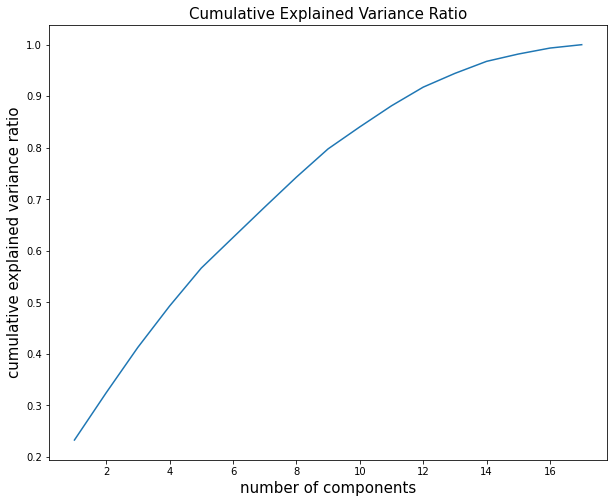

In [ ]:
plt.figure(num=5,figsize=(10,8))
plt.plot(range(1,len(cum_evr_spark)+1),cum_evr_spark)
plt.xlabel('number of components',fontsize=15)
plt.ylabel('cumulative explained variance ratio',fontsize=15)
plt.title('Cumulative Explained Variance Ratio',fontsize=15)
plt.show()

In [ ]:
pca = PCA(k=12,inputCol='standard_features',outputCol='pcaFeatures')
pca_model = pca.fit(stand_train)
pca_train = pca_model.transform(stand_train)

In [ ]:
LR = LogisticRegression(featuresCol="pcaFeatures",labelCol="above_average").fit(pca_train)

In [ ]:
# TO-DO: Evaluate predictions on train and call this "training_ROC_area_pca"
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='above_average')
predictions_train = LR.transform(pca_train)
training_ROC_area_pca = evaluator.evaluate(predictions_train,{evaluator.metricName:"areaUnderROC"})
# TO-DO: Evaluate predictions on test and call this "test_ROC_area_pca"
stand_model2 = standardScaler.fit(test_sdf)
stand_test = stand_model2.transform(test_sdf)
pca_test = pca_model.transform(stand_test)
predictions_test = LR.transform(pca_test)
test_ROC_area_pca = evaluator.evaluate(predictions_test,{evaluator.metricName:"areaUnderROC"})

In [ ]:
# 8 points
grader.grade(test_case_id = 'check_pca', answer = (training_ROC_area_pca, test_ROC_area_pca))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Homework Submission

Good job! You finished the homework :) The submission instructions are as follows:

* **Double check** that you have the correct PennID (all numbers) in the autograder. 

* **Triple check** that you have all plots shown in this Colab notebook before submitting (otherwise subject to a **penalty of -3 points**)

*  Go to the "File" tab at the top left, and click "Download .ipynb" and then "Download .py".  **Rename** the files to "homework4.ipynb" and "homework4.py" respectively and upload them to Gradescope.

* You must submit your notebook to receive credit. Post any issues with submission on Piazza and make sure to keep in mind the late day policy.

* We will do a manual round of grading to sanity check that the stuff you have .
